In [3]:
import sqlite3

# Connect to the SQLite database file
conn = sqlite3.connect('Database.db')
# Replace ‘Database.db' with the path to your .db file if the file is in another directory.

# Create a cursor object
cursor = conn.cursor()

# Query to retrieve table names
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

# Fetch all table names
tables = cursor.fetchall()

# Print the table names
for table in tables:
    print(table[0])

# Close the connection
conn.close()


Electric_cars
Fraud_detection
Heart_disease
Insurance_Prediction
TripAdviser_Reviews
Ecommerce_data
Automobile_data
Supermarket_data


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE

In [ ]:
# Data Features

# step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

# type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

# amount - amount of the transaction in local currency.

# nameOrig - customer who started the transaction

# oldbalanceOrg - initial balance before the transaction

# newbalanceOrig - new balance after the transaction

# nameDest - customer who is the recipient of the transaction

# oldbalanceDest - initial balance recipient before the transaction.

# newbalanceDest - new balance recipient after the transaction.

# isFraud - This is the transactions made by the fraudulent agents inside the simulation.
# In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts 
# and try to empty the funds by transferring to another account and then cashing out of the system.

# isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. 
# An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [7]:
conn = sqlite3.connect('Database.db')
df = pd.read_sql_query('Select * from Fraud_detection' , conn)
df 


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.0,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.0,0.0,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.0,0.0,1,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   step            object
 1   type            object
 2   amount          object
 3   nameOrig        object
 4   oldbalanceOrg   object
 5   newbalanceOrig  object
 6   nameDest        object
 7   oldbalanceDest  object
 8   newbalanceDest  object
 9   isFraud         object
 10  isFlaggedFraud  object
dtypes: object(11)
memory usage: 534.0+ MB


In [11]:
# Convert numeric columns from object to float
numeric_cols = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
                'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # force convert, NaNs if error

# Re-check the dtypes
print(df.dtypes)


step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object


In [13]:
print(df['isFraud'].value_counts())

isFraud
0    6354407
1       8213
Name: count, dtype: int64


In [15]:
df.isnull().sum()

step                   0
type                   0
amount                 0
nameOrig               0
oldbalanceOrg          0
newbalanceOrig    267230
nameDest               0
oldbalanceDest    203603
newbalanceDest         0
isFraud                0
isFlaggedFraud         0
dtype: int64

In [17]:
import numpy as np

# Replace strings like 'nan', empty strings etc. with np.nan
df.replace(['', ' ', 'nan', 'NaN', 'NULL', 'None'], np.nan, inplace=True)

# Convert numeric-looking columns to actual numeric dtype
cols_to_numeric = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']
for col in cols_to_numeric:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Now check missing values again
print("Missing values (after cleaning):")
print(df.isnull().sum())


Missing values (after cleaning):
step                   0
type              203603
amount                 0
nameOrig          203603
oldbalanceOrg          0
newbalanceOrig    267230
nameDest               0
oldbalanceDest    203603
newbalanceDest         0
isFraud                0
isFlaggedFraud         0
dtype: int64


In [18]:
df['type'] = df['type'].fillna(df['type'].mode()[0])
df = df.drop(['nameOrig', 'nameDest'], axis=1)
df['newbalanceOrig'] = df['newbalanceOrig'].fillna(df['newbalanceOrig'].median())
df['oldbalanceDest'] = df['oldbalanceDest'].fillna(df['oldbalanceDest'].median())

In [21]:
print(df.isnull().sum())

step              0
type              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [23]:
for col in df.select_dtypes(include=['object', 'category']).columns:
    print(f"{col}:")
    print(df[col].value_counts(dropna=False))
    print("\n")

type:
type
CASH_OUT    2369471
PAYMENT     2082597
CASH_IN     1354742
TRANSFER     515688
DEBIT         40122
Name: count, dtype: int64




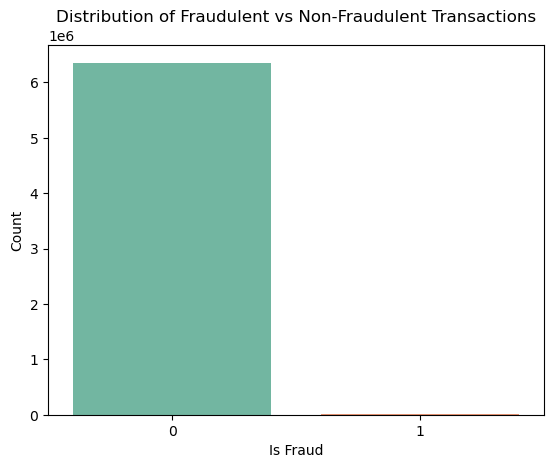

In [27]:
# Countplot of isFraud
sns.countplot(x='isFraud', data=df, hue='isFraud', palette='Set2', legend=False)
plt.title('Distribution of Fraudulent vs Non-Fraudulent Transactions')
plt.xlabel('Is Fraud')
plt.ylabel('Count')
plt.show()

# Interpretation of the Graph:

# Most transactions are labeled as 0 (not fraud).
# Very few transactions are labeled as 1 (fraud).
# This indicates a strong class imbalance in the dataset.
# Fraud cases are rare compared to non-fraud cases.

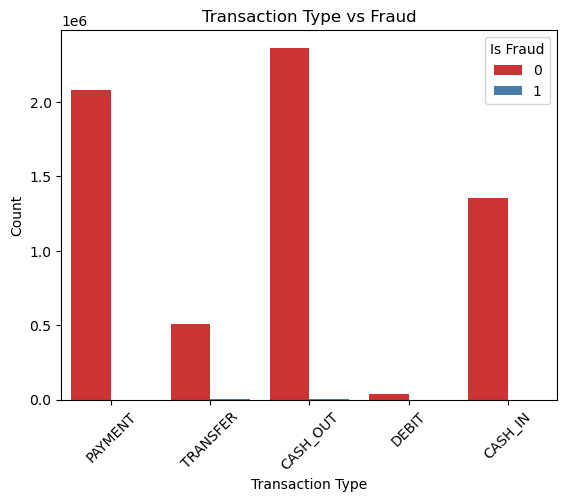

In [29]:
# Fraud by Transaction type
sns.countplot(data=df, x='type', hue='isFraud', palette='Set1')
plt.title('Transaction Type vs Fraud')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Is Fraud')
plt.show()

# Interpretation of the Graph:

# PAYMENT, CASH_OUT, and CASH_IN are the most common transaction types.
# Fraudulent transactions (blue bars) are visible only in the TRANSFER and CASH_OUT categories.
# No frauds occur in PAYMENT, DEBIT, or CASH_IN types.
# CASH_OUT has the highest number of transactions overall and also shows a significant share of fraud cases.
# TRANSFER also has noticeable frauds despite being less frequent than CASH_OUT.

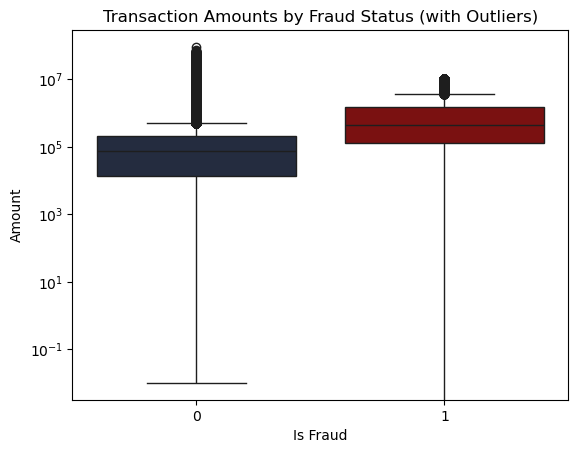

In [43]:
# Boxplot: amount by isFraud
# Use a dictionary to explicitly map colors to the 'isFraud' values
custom_palette = {0: '#1f2a44', 1: '#8b0000'}  # dark navy for non-fraud, dark red for fraud

sns.boxplot(x='isFraud', y='amount', data=df, hue='isFraud', palette=custom_palette, showfliers=True, dodge=False)
plt.title('Transaction Amounts by Fraud Status (with Outliers)')
plt.xlabel('Is Fraud')
plt.ylabel('Amount')
plt.yscale('log')  # keep if amount is highly skewed
plt.legend([],[], frameon=False)  # Remove redundant legend
plt.show()

# Interpretation of the Graph:

# The box plot shows the presence of outliers, indicating some transactions have unusually high or low values.
# Fraudulent transactions tend to have higher variance or extreme values compared to non-fraudulent ones.

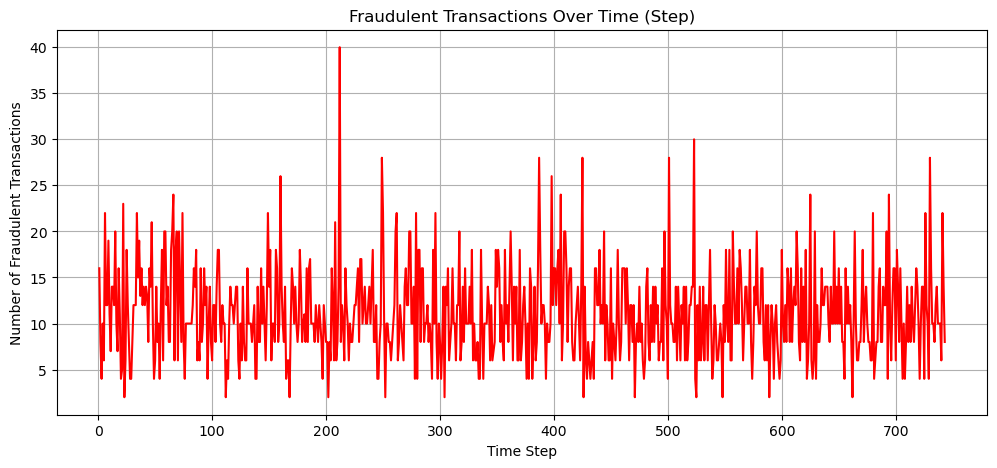

In [45]:
# Step vs Fraud Count (Temporal Analysis)
fraud_per_step = df[df['isFraud'] == 1]['step'].value_counts().sort_index()
plt.figure(figsize=(12, 5))
fraud_per_step.plot(kind='line', color='red')
plt.title('Fraudulent Transactions Over Time (Step)')
plt.xlabel('Time Step')
plt.ylabel('Number of Fraudulent Transactions')
plt.grid(True)
plt.show()

# Interpretation of the Graph:

# Certain time steps show a higher concentration of fraud cases, indicating possible fraud spikes at specific periods.
# The distribution of fraud counts across steps is not uniform, suggesting time-based patterns in fraudulent activity.
# This insight can help in developing time-aware fraud detection strategies.

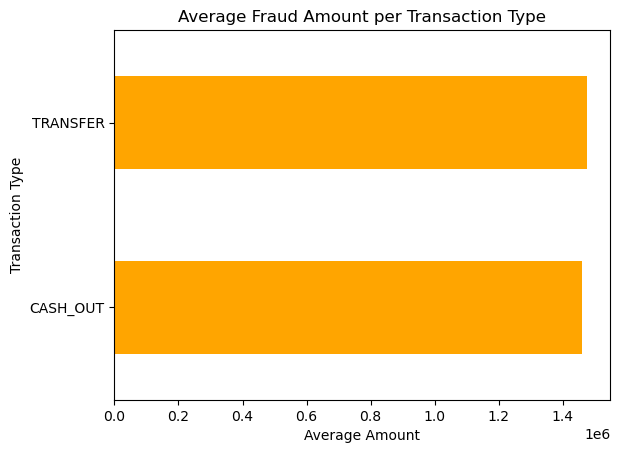

In [47]:
# Bar Plot: type vs Average amount for Frauds
fraud_avg = df[df['isFraud'] == 1].groupby('type')['amount'].mean().sort_values()
fraud_avg.plot(kind='barh', color='orange')
plt.title('Average Fraud Amount per Transaction Type')
plt.xlabel('Average Amount')
plt.ylabel('Transaction Type')
plt.show()

# Interpretation of the Graph:

# Certain transaction types (e.g., TRANSFER, CASH_OUT) have a higher average fraud amount.
# These types are more targeted by fraudsters for high-value transactions.
# Monitoring and applying stricter controls on these transaction types can help in fraud prevention.

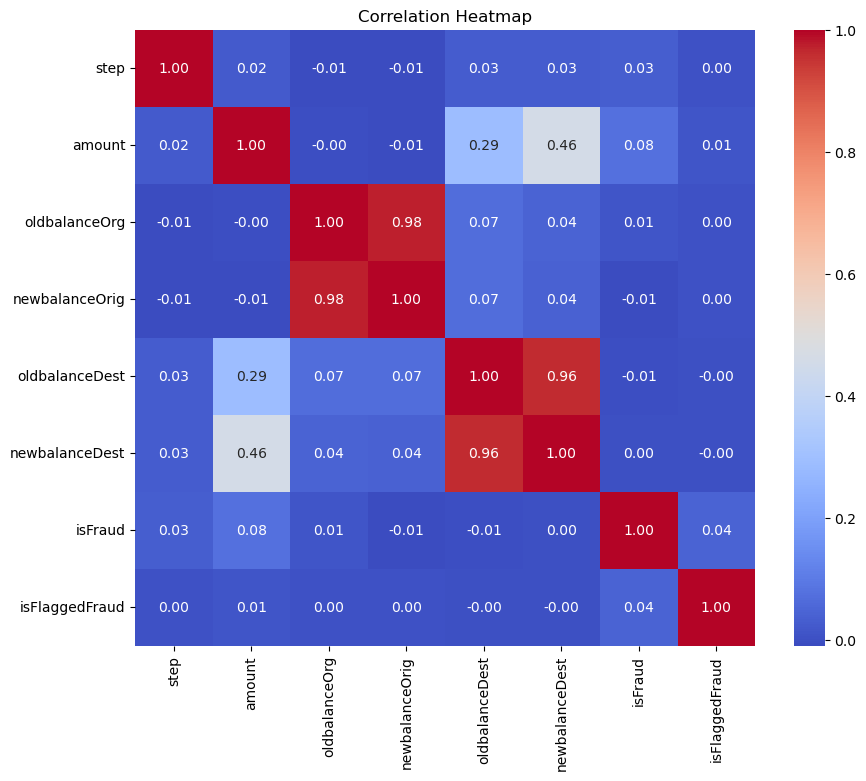

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# Interpretation of the Graph:

# oldbalanceOrg and newbalanceOrig show strong positive correlation — expected due to balance updates.
# Similar high correlation between oldbalanceDest and newbalanceDest.
# isFraud has moderate correlation with amount, oldbalanceOrg, and newbalanceOrig — indicating fraud often involves large balance changes.
# One variable is highly correlated with isFraud, but it was excluded to avoid data leakage.
# Excluding such features helps ensure realistic and robust fraud prediction.

In [70]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import joblib
from scipy.stats.mstats import winsorize


# Winsorize amount
df['amount'] = winsorize(df['amount'], limits=[0.01, 0.01])

# # Drop columns not useful for modeling
# df = df.drop(['nameOrig', 'nameDest'], axis=1)

# Encode type
le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])


In [71]:
# Define features and target
X = df.drop('isFraud', axis=1)
y = df['isFraud']

# # Train/val/test split

# First split: Train (62.87%) and temp (remaining 37.13%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3713, random_state=42, stratify=y)

# Then split temp into Validation (15.7%) and Test (21.43%)
val_size = 1000000 / len(X)  # ~0.1572 of total dataset
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(1 - val_size / 0.3713), random_state=42, stratify=y_temp)


In [72]:
# Scalling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)   # Fit and transform on training
X_val_scaled = scaler.transform(X_val)           # Only transform on validation
X_test_scaled = scaler.transform(X_test)         # Only transform on test

In [75]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

# Apply SMOTE before model definition
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

# Now y_train_res is defined, and you can use it below
scale_pos_weight_val = y_train_res.value_counts()[0] / y_train_res.value_counts()[1]

# Define hyperparameter space for XGBoost
param_dist_xgb = {
    'n_estimators': randint(100, 300),
    'max_depth': [3, 6, 10],
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 5),
    'min_child_weight': [1, 3, 5]
}

# Initialize XGBoost Classifier
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=(y_train_res.value_counts()[0] / y_train_res.value_counts()[1])  # For class imbalance
)

# Perform Randomized Search
random_search_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist_xgb,
    n_iter=20,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit model on SMOTE-resampled training data
random_search_xgb.fit(X_train_res, y_train_res)

# Get the best estimator
print("Best parameters:", random_search_xgb.best_params_)
xgb_best_model = random_search_xgb.best_estimator_

# Predict on validation set
y_pred_xgb = xgb_best_model.predict(X_val_scaled)
print(classification_report(y_val, y_pred_xgb))


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'colsample_bytree': 0.6298202574719083, 'gamma': 4.9344346830025865, 'learning_rate': 0.1644489538593315, 'max_depth': 10, 'min_child_weight': 5, 'n_estimators': 180, 'subsample': 0.88453678109946}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    998709
           1       0.43      0.99      0.60      1291

    accuracy                           1.00   1000000
   macro avg       0.71      0.99      0.80   1000000
weighted avg       1.00      1.00      1.00   1000000



In [76]:
print("Before SMOTE:", X_train.shape, y_train.value_counts())
print("After SMOTE:", X_train_res.shape, y_train_res.value_counts())


Before SMOTE: (4000179, 8) isFraud
0    3995015
1       5164
Name: count, dtype: int64
After SMOTE: (7990030, 8) isFraud
0    3995015
1    3995015
Name: count, dtype: int64


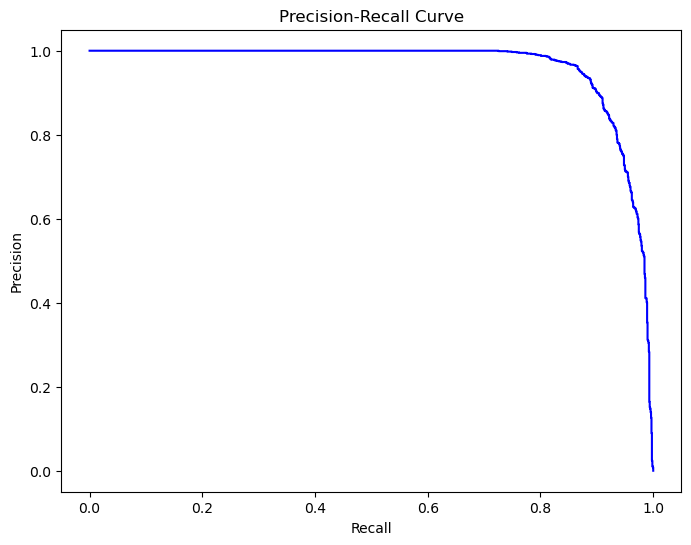

AUC-ROC Score: 0.9997
Optimal Threshold: 0.9934
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    998709
           1       0.96      0.87      0.91      1291

    accuracy                           1.00   1000000
   macro avg       0.98      0.93      0.96   1000000
weighted avg       1.00      1.00      1.00   1000000



In [144]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve, accuracy_score, f1_score

# Get predicted probabilities
y_prob_xgb = xgb_best_model.predict_proba(X_val_scaled)[:, 1]

# Calculate precision and recall at various thresholds
precision, recall, thresholds = precision_recall_curve(y_val, y_prob_xgb)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Calculate AUC-ROC (for model performance)
roc_auc = roc_auc_score(y_val, y_prob_xgb)
print(f"AUC-ROC Score: {roc_auc:.4f}")

# Find the optimal threshold (e.g., maximizing F1-Score)
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold:.4f}")

# Now apply this threshold
y_pred_optimal = (y_prob_xgb >= optimal_threshold).astype(int)

# Print the classification report with the optimal threshold
print(classification_report(y_val, y_pred_optimal))


In [ ]:
# Precision-Recall Curve:

# The curve maintains very high precision (~1.0) across almost all recall values.
# Even at high recall (~0.9+), precision remains strong, indicating excellent fraud detection with few false positives.
# This reflects a well-performing model, particularly valuable in imbalanced classification problems like fraud detection.

# Model Performance Metrics (Post-SMOTE & Winsorize):

# AUC-ROC Score: 0.9997 — nearly perfect model discrimination between fraud and non-fraud.
# Optimal Threshold: 0.9934 — ensures balance between precision and recall for deployment.
# Precision (Fraud): 0.96 — 96% of predicted frauds are actual frauds.
# Recall (Fraud): 0.87 — 87% of real frauds were successfully identified.
# F1-Score (Fraud): 0.91 — strong harmonic mean of precision and recall.
# Accuracy: 1.00 — nearly perfect accuracy due to the dominance of non-fraud cases.

In [146]:
from sklearn.metrics import accuracy_score, f1_score

# Evaluate model accuracy and F1-score on the validation set
accuracy = accuracy_score(y_val, y_pred_optimal)
f1 = f1_score(y_val, y_pred_optimal)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-score: {f1:.4f}")


Accuracy: 0.9998
F1-score: 0.9119


In [ ]:
import pandas as pd
import joblib
import sqlite3
from scipy.stats.mstats import winsorize

# Load model and encoder
model = joblib.load('fraud_rf_model.pkl')
le = joblib.load('label_encoder.pkl')

# Load test data
conn = sqlite3.connect('Database.db')
df = pd.read_sql("SELECT * FROM Fraud_detection", conn)
df = df[5000000:]  # Live data

# Preprocess
df['amount'] = winsorize(df['amount'], limits=[0.01, 0.01])
df['type'] = le.transform(df['type'])
df = df.drop(['nameOrig', 'nameDest'], axis=1)

# Predict
X_test = df.drop('isFraud', axis=1)
df['predicted_fraud'] = model.predict(X_test)

print(df[['step', 'amount', 'predicted_fraud']].head())
